In [25]:
from astropy.io import fits
from astropy.modeling import models
import numpy as np
from matplotlib import pyplot as plt
from azimuthalAverage import azimuthalAverage
%pylab nbagg

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [26]:
##
## helper function to read MIDI OIFITS visibility file
def read_midi_oifits(f):
	hdu=fits.open(f)
	w=hdu[3].data
	ww=w["EFF_WAVE"]
#	ix=(ww>12.2e-6)&(ww<12.8e-6)
	ix=(ww>9.8e-6)&(ww<10.2e-6)
	
	v=hdu[4].data
	vv=v["VISAMP"]
	vis = np.average(vv[:,ix],axis=1)
	bl=np.sqrt(v["UCOORD"]**2+v["VCOORD"]**2)
	return(bl,vis)

In [27]:
##
## helper function to read MIDI OIFITS correlated flux file
##
## requires estimate of total flux (phot) to compute visibility
##
def read_midi_oifits_corrflx(f,phot):
	hdu=fits.open(f)
	w=hdu[3].data
	ww=w["EFF_WAVE"]
#	ix=(ww>12.2e-6)&(ww<12.8e-6)
	ix=(ww>9.8e-6)&(ww<10.2e-6)
	
	v=hdu[4].data
	vv=v["CFLUX"]
	vis = np.average(vv[:,ix],axis=1) / phot
	bl=np.sqrt(v["UCOORD"]**2+v["VCOORD"]**2)
	return(bl,vis)

In [28]:
##
## core function to compute visibility
##
## source can be either "ngc1068" or "circinus"
##
def fft(f_model,source):

	if source=="ngc1068":
		print("Computing visibilities for NGC 1068 model")
	elif source=="circinus":
		print("Computing visibilities for Circinus model")
	else:
		raise ValueError("Unknown source ", source)

	##
	## one pixel = 5 mas
	##
	#pxscale=5 ## in mas
	#gridsize=2000 ## half-size of grid size in mas



	lam=10e-6 ## observation wavelength
	
	if (source=="ngc1068") & (lam != 10e-6):
		raise ValueError("Need to adapt total flux of source for MIDI visibility calculation!")

	#fwhm_gauss=10
	#f_p = 0.0
	#g=models.Gaussian2D(1,0,0,fwhm_gauss/pxscale,fwhm_gauss/pxscale)
	#y,x=np.mgrid[-gridsize/pxscale:gridsize/pxscale,-gridsize/pxscale:gridsize/pxscale]
	#img = g(x,y)

	##
	## choose model / object #######################################################
	##
	f_Circinus="MIDI_data/Circinus.oifits"
	f_1068="MIDI_data/NGC1068.oifits"

	if source=="ngc1068":
		bl,vis_obs=read_midi_oifits_corrflx(f_1068,10.5) ## 1068, 10 micron
		pxscale=0.08 * 1000/71 ### 0.08 pc per px, 1000 mas = 71 pc in NGC 1068
	else:
		bl,vis_obs=read_midi_oifits(f_Circinus) ## Circinus
		pxscale=0.08 * 1000/20 ### 0.08 pc per px, 1000 mas = 20 pc in Circinus

	hdu=fits.open(f_model)
	img=hdu[0].data

	##
	## end of model / object specific code #########################################
	##

	img=img[0:500,0:500]
	gridsize=img.shape[0]

	##
	## compute fringe factor, i.e. factor to multiply FFT image with to get 1 px = 1 m in (u,v) space
	fringe_factor = 128.86/200 * (lam/12.5e-6) * (2000/gridsize) ## calibration factor from a 10 mas separation binary -- zero vis at 128.86 m at 12.5 micron -- has its minimum at pixel 200


	F_g = np.sum(img)
	##
	## add point source to image
	#img[gridsize/pxscale,gridsize/pxscale] += f_p * F_g / (1-f_p)
	#img[gridsize/pxscale,gridsize/pxscale] += 10000
	#img[gridsize/pxscale,(10+gridsize)/pxscale] += 10000
	fft_img = np.abs(np.fft.rfft2(img))
	roll=fft_img.shape[0]/2

	if (roll-np.floor(roll)) != 0:
		raise ValueError("roll is not an integer")
	roll=np.int(roll)

	vis_norm=fft_img[0,0]
	vis=np.roll(fft_img,roll,0)/vis_norm

	plt.subplot(221)
	## cut out central region
	c_mas = 100 ## half-size of cut-out box (in mas)
	c_px = c_mas/pxscale
	p1 = np.shape(img)[0]/2 - c_px
	p2 = np.shape(img)[0]/2 + c_px
	img_cut = img[p1:p2,p1:p2]
	plt.imshow(img_cut/np.max(img_cut),origin="lower")
	plt.colorbar(label="Normalized intensity")
	plt.title("Image plane")
	#lamstr=str(r"$\lambda$ = {0} m".format(lam))
	#plt.annotate(lamstr,(5,160),color="white")
	##
	## set number of axis labels
	nax=5
	xt = 2 * c_px * np.arange(nax+1)/nax
	xt_label = pxscale * xt
	plt.xticks(xt,xt_label - c_mas)
	plt.yticks(xt,xt_label - c_mas)
	plt.xlabel("x [mas]")
	plt.ylabel("y [mas]")


	plt.subplot(222)
	plt.imshow(vis,origin="lower")
	plt.colorbar(label="Visibility amplitude")
	plt.title("Fourier plane")
	nax=3
	xt = vis.shape[1] * np.arange(nax+1)/nax
	yt = vis.shape[0] * np.arange(2*nax+1)/(2*nax)
	plt.xticks(xt,(fringe_factor*xt).astype(int))
	plt.yticks(yt,(fringe_factor*(yt-roll)).astype(int))
	plt.xlabel("u [m]")
	plt.ylabel("v [m]")


	plt.subplot(223)
	r,V = azimuthalAverage(vis,center=[0,roll],returnradii=True)
	plt.plot(fringe_factor * r,V)
	plt.ylim([0,1])
	plt.xlim([0,130])
	plt.xlabel("Projected baseline [m]")
	plt.ylabel("Visibility amplitude")
	plt.title("Azimuthally averaged visibility amplitude")

	plt.plot(bl,vis_obs,'ks',label="MIDI data")
	plt.legend(numpoints=1)


	plt.subplot(224)
	plt.plot(fringe_factor * np.arange(vis.shape[1]),vis[roll,:])
	plt.ylim([0,1])
	plt.xlim([0,130])
	plt.xlabel("Projected baseline [m]")
	plt.ylabel("Visibility amplitude")
	plt.title("Meridional cut through (u,v) plane")


	plt.suptitle(f_model.split(".fits")[0] + str(" (lam={0} m)".format(lam)))

	plt.tight_layout()

Computing visibilities for Circinus model


<IPython.core.display.Javascript object>


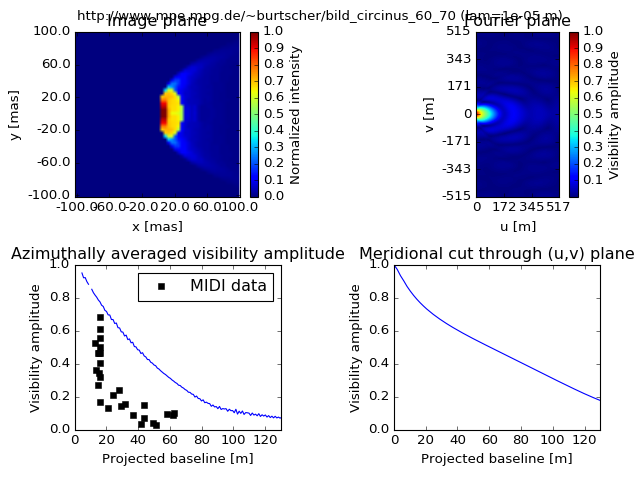

/usr/local/lib/python3.5/site-packages/ipykernel/__main__.py:84: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/leo/Projekte/diskwind_model/img2vis/azimuthalAverage.py:73: RuntimeWarning: invalid value encountered in true_divide
  radial_prof = np.histogram(r, bins, weights=(image*weights*mask))[0] / np.histogram(r, bins, weights=(mask*weights))[0]


In [29]:
url_base="http://www.mpe.mpg.de/~burtscher/"
img="bild_circinus_60_70.fits"
fft(url_base+img,"circinus")
plt.savefig(img.split(".fits")[0]+".png",dpi=300)